# Reconstruction Analysis True Hits (RATH)
- Run the reconstruction analysis for True hits (RATH).
    - The RATH voxelises MC True Hits, then computes TrackGraphs and find voxels extremes.
    - The driver returns an object containing relevant statistics and a EventTrack object, that is, a list, indexed by event number of GTRacks.
- Saves and loads from disk
    - This documents the use of functions that can be used to save the output of a RATH run. 

##### General

In [16]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
import functools
import time

from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import networkx as nx
from itertools   import combinations

In [4]:
from pandas import DataFrame, Series
from typing import List, Tuple
from typing import Union
from   dataclasses import dataclass

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

##### IC

In [7]:

import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


##### TICs

In [8]:
from tics.histograms    import h1
from tics.pd_tics       import get_index_slice_from_multi_index
from tics.pd_tics   import slice_and_select_df
from tics.graphics_reco import plot_hits3d
from tics.stats_tics    import bin_data_with_equal_bin_size
from tics.util_tics import get_class_name
from tics.util_tics import Range
from tics.graphics_reco import plot_gtrack
from tics.system_of_units import *

##### NetFlex

In [9]:
from nextflex.core import Setup

In [10]:
from nextflex.core import Setup
from nextflex.mctrue_functions import get_mc_particles
from nextflex.mctrue_functions import get_mc_primary_particles
from nextflex.mctrue_functions import get_mc_vertex
from nextflex.mctrue_functions import select_mc_particles
from nextflex.mctrue_functions import get_mc_hits
from nextflex.mctrue_functions import select_mc_hits
from nextflex.mctrue_functions import total_hit_energy
from nextflex.mctrue_functions import get_event_hits_from_mchits

In [11]:
from nextflex.reco_functions import voxelize_hits
from nextflex.reco_functions import get_voxels_as_list
from nextflex.reco_functions import voxel_position
from nextflex.reco_functions import voxel_energy
from nextflex.reco_functions import voxel_nhits
from nextflex.reco_functions import distance_between_two_voxels
from nextflex.reco_functions import voxel_distances
from nextflex.reco_functions import voxel_distance_pairs
from nextflex.reco_functions import make_track_graphs
from nextflex.reco_functions import gtrack_voxels
from nextflex.reco_functions import shortest_paths
from nextflex.reco_functions import find_extrema_and_length
from nextflex.reco_functions import GTrack
from nextflex.reco_functions import GTracks
from nextflex.reco_functions import voxels_in_blob
from nextflex.reco_functions import blob_energy


In [12]:
from nextflex.io import write_gtracks_json
from nextflex.io import load_gtracks_json
from nextflex.io import write_event_gtracks_json
from nextflex.io import load_event_gtracks_json
from nextflex.io import save_to_JSON
from nextflex.io import load_from_JSON

In [169]:
from nextflex.reco_analysis import reco_gtrack_from_mc_hits
from nextflex.reco_analysis import reco_gtrack_blobs
from nextflex.reco_analysis import TrackRecoStats
from nextflex.reco_analysis import TrackRecoTiming
from nextflex.reco_analysis import TrackRecoEventStats
from nextflex.reco_analysis import GtrkStats
from nextflex.reco_analysis import gtrack_summary
from nextflex.reco_analysis import select_gtrack_topology
from nextflex.reco_analysis import distance_between_extrema
from nextflex.reco_analysis import gtrack_df
from nextflex.reco_analysis import event_list_by_multiplicity
from nextflex.reco_analysis import tExtrema_df
from nextflex.reco_analysis import RecoGtrackFromMcHits

In [14]:
from nextflex.analysis_histos import reco_gtrack_stats_histos
from nextflex.analysis_histos import reco_gtrack_timing_histos
from nextflex.analysis_histos import reco_gtrack_blobs_histos
from nextflex.analysis_graphics import plot_single_tracks_list
from nextflex.analysis_graphics import plot_multiple_tracks_list

In [15]:
from nextflex.types import EventHits
from nextflex.types import VoxelHits


### Input data

In [17]:
FDATA = os.environ['FLEXDATA']

In [18]:
setup = Setup(flexDATA = FDATA,
              sipmPDE  = 1.0,
              maskPDE  = 1.0,
              qTh      = 0.0,
              tpConfig = "FLEX100_M6_O6_EL8bar_bb0nu")
print(setup)


        Setup <FLEX100_M6_O6_EL8bar_bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6_EL8bar_bb0nu
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 15.55
        number of energy sensors     = 60
        number of SiPMs              = 3093
        root directory               = /Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu
        analysis directory           = /Users/jj/Development/flexdata/analysis/FLEX100_M6_O6_EL8bar_bb0nu
        number of h5 files in dir    = 206
        sipm map at                  = /Users/jj/Development/flexdata/flexmaps/sipm_map_15.6_mm.csv
        sipm map name                = sipm_map_15.6_mm.csv
        output file                  = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_EL8bar_bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.cs

In [19]:
ifnames = glob.glob(f"{FDATA}/{setup.tpConfig}/*.h5")
print(f'found {len(ifnames)} files')

found 206 files


### Run 

#### The driver

***
@dataclass\
class RecoGtrackFromMcHits:

    """
    This class collects all information relevant for the topological
    analysis of reconstructed tracks (from monte carlo hits), plus
    statistics information.
    """
    recoSetup           : Setup
    voxel_bin           : float
    contiguity          : float 
    gtracks             : List[GTracks]        = None
    tExtrema            : pd.DataFrame         = None
    trackRecoStats      : pd.DataFrame         = None
    trackRecoTiming     : pd.DataFrame         = None
    tVoxelizationXYZ    : pd.DataFrame         = None
    trackRecoEventStats : TrackRecoEventStats  = None

*** 
- The driver for the reconstruction of gtracks (graph tracks) from Monte Carlo hits takes as parameters:
    - The setup which is used internally for bookeeping (where to read/write files)
    - The voxel_bin and contiguity which define the voxelisation 
    - The topology specifying which hits are used from the MC Hits (all or only from primary particles)
    - The event type (which can be bb0nu or 1e)
    - The baryc parameter which specifies if the position of the voxel is computed from the barycenter of the hits or from the average
    - debug, file_range to use and frequency of printing

- The driver returns an object **RecoGtrackFromMcHits** which has the following fields:
    - Setup, voxel_bin and contiguity.
    - a list of GTracks (each GTracks object is a list of GTrack or graph-track object)
    - a DF describing the true extrema for each track
    - Track reconstruction statistics (a DF)
    - Track reconstruction timing (a DF)
    - a DF which allows measurement of voxelisation timing versus number of voxels 
    - Information on track reconstruction event statistics

In [184]:
voxel_bin  = 5.
rb         = 10
contiguity = 10

In [183]:
rgt  = reco_gtrack_from_mc_hits(setup, voxel_bin, contiguity,
                                topology   = "all",
                                event_type = "bb0nu",
                                baryc      = True,
                                debug      = False,
                                file_range = (0, -1),
                                ic         = 20)

file number = 20, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.17.next.h5
file number = 40, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.210.next.h5
file number = 60, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.180.next.h5
file number = 80, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.40.next.h5
file number = 100, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.83.next.h5
file number = 120, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.86.next.h5
file number = 140, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.147.next.h5
file number = 160, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.241.

##### Event statistics

In [185]:
rgt.trackRecoEventStats


        <Track Reconstruction Statistics>
        size of voxel bins          = 5.0
        contiguity parameter        = 10
        topology                    = all
        event type                  = bb0nu
        voxels from hits barycenter = True
        number of files analyzed    = 205
        number of events analyized  = 815
        number of events 1 GT       = 537
        

##### Time vs binning

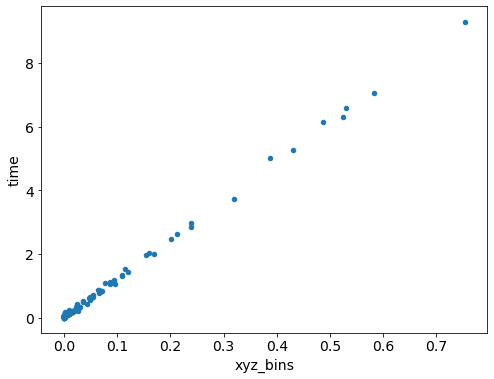

In [186]:
ax1 = rgt.tVoxelizationXYZ.plot.scatter(x='xyz_bins', y='time')

##### Reco stats

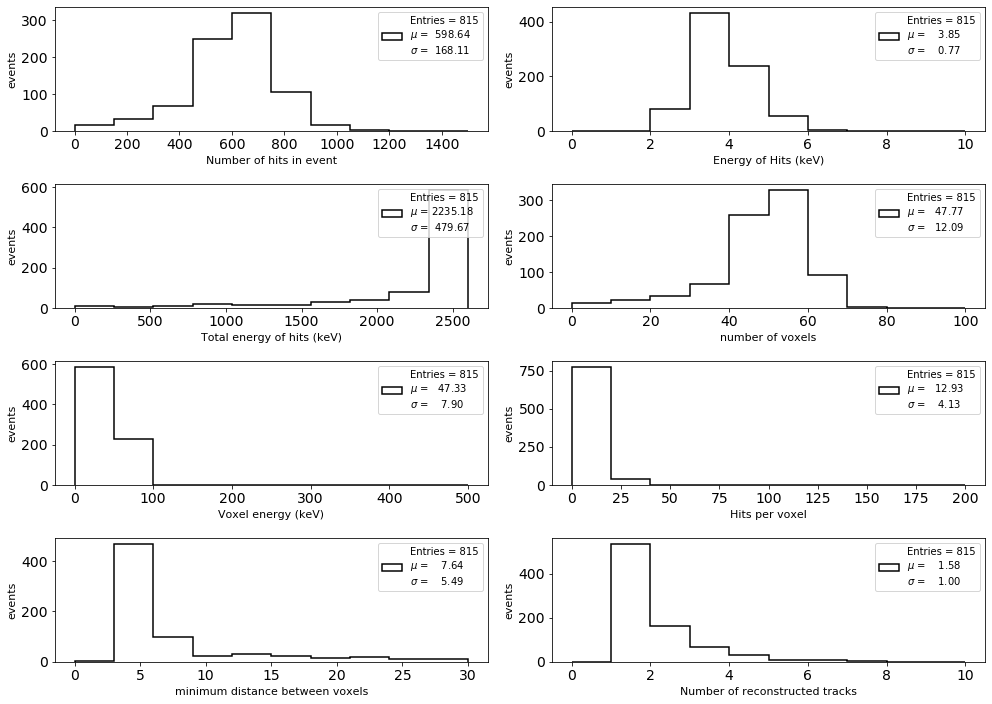

In [187]:
reco_gtrack_stats_histos(rgt.trackRecoStats, energy_evt_hits = (0,10),  min_dist_voxels = (0,30),figsize=(14,10))

##### Timing stats

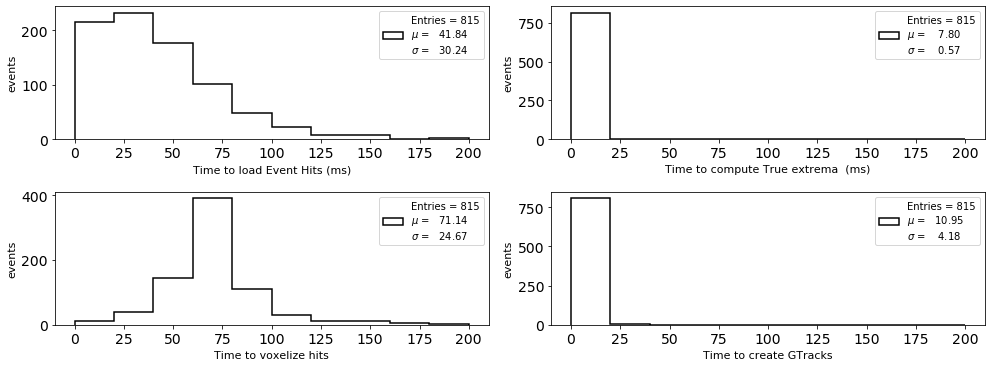

In [188]:
reco_gtrack_timing_histos(rgt.trackRecoTiming, figsize=(14,10))

##### Graph tracks

In [189]:
graphTracks = gtrack_df(rgt.gtracks, rb)

In [190]:
graphTracks.head()

event_id  track_id  n_voxels  trak_length       energy  \
evt_number trk_number                                                           
0          0                212         0        47   128.388471  2267.494424   
           1                212         1         1     0.000000    12.581009   
           2                212         2         1     0.000000    29.781301   
           3                212         3         1     0.000000   132.281467   
1          0                213         0        61   137.483020  2439.155334   

                             x_e1        y_e1        z_e1  energy_e1  nvox_b1  \
evt_number trk_number                                                           
0          0          -161.863903 -410.403261  799.438663   0.209614        4   
           1          -154.306005 -210.879696  907.142098   0.012581        1   
           2          -110.534864 -155.678515  899.274488   0.029781        1   
           3          -107.638045 -171.495649  902.835057   0.132281        1   
1          0          -242.520752  283.138306  717.443176   0.007230        6   

                        energy_b1        x_e2        y_e2        z_e2  \
evt_number trk_number                                                   
0          0           425.707355 -114.430321 -433.747009  787.070068   
           1            12.581009 -154.306005 -210.879696  907.142098   
           2            29.781301 -110.534864 -155.678515  899.274488   
           3           132.281467 -107.638045 -171.495649  902.835057   
1          0           169.272269 -227.169733  278.949920  649.013203   

                       energy_e2  nvox_b2   energy_b2  
evt_number trk_number                                  
0          0            0.048411        6  449.074414  
           1            0.012581        1   12.581009  
           2            0.029781        1   29.781301  
           3            0.132281        1  132.281467  
1          0            0.104347        5  349.851433

##### True extrema

In [191]:
rgt.tExtrema.head()

x           y           z      time  \
evt_number extreme_number                                                 
0          0              -161.862625 -410.048401  798.626526  0.307825   
           1              -112.179108 -434.243652  786.763184  0.503191   
1          0              -227.316559  279.183472  648.786682  0.072518   
           1              -233.384613  269.778229  709.347168  0.835184   
2          0              -140.505875  -67.944786  101.531654  0.898091   

                             energy  
evt_number extreme_number            
0          0               3.007836  
           1               0.601369  
1          0               4.137615  
           1               3.842203  
2          0               1.649465

##### 1 track efficiency

In [192]:
print(f"bb0nu efficiency = {rgt.trackRecoEventStats.e_gt/rgt.trackRecoEventStats.e_total}")

bb0nu efficiency = 0.6588957055214724


### Save and load to/from disk

#### write

In [193]:
rgt.write_setup()